# Prediction Intervals for Trees using Conformal Intervals - pitci
This notebook shows some simple usage of the [pitci package](https://github.com/richardangell/pitci). This is a new package that allows predictions intervals to be generated for tree based models using conformal intervals. <br>

The basic idea of (inductive) conformal intervals is to use a calibration set to learn given quantile of the error distribution, on that set. Here we are simply using the absolute value of the difference between the response and predictions. This quantile is used as the basis for predictions intervals. <br>

However it is not very useful in it's default state - which gives the same interval for every new prediction. Instead we want to scale this interval according to the data we want to make predictions on. Intuitively we want to increase the interval where we have less confidence about the data and decrease it where we have more confidence. <br>

In order to produce a value that captures the confidence or familiarity we have we some data, compared to our calibration set, `pitci` uses 1 / the number of times each leaf node used to generate a prediction was visited across all rows of the calibration set and then summed across trees. The reason for the reciproal is to invert the measure so a smaller value is better hence reducing the size of intervals for records we are more confident in. <br>

# Diabetes Dataset Regression
Below is an example of using the `pitic` package to generate prediction intervals with [xgboost](https://xgboost.readthedocs.io/en/latest/) on the [diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset), available in [scikit-learn](https://scikit-learn.org/stable/index.html).

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

In [2]:
import pitci
pitci.__version__

'0.2.0'

## Build example xgboost model
The `pitci` package works with an existing xgboost model, first we'll build a model on the diabetes dataset.

### Load data from scikit-learn

In [3]:
diabetes = load_diabetes()

### Create xgboost matrices
We will split the diabetes dataset into 4 samples that will be used in the following ways; <br>
1. `train` used to fit the model <br>
2. `validate` used for early stopping when training, to select the best number of trees to use in the model <br>
3. `interval` used for fitting or calibrating the conformal interval information that will be used when generating prediction intervals <br>
4. `test` used for evaluating model and interval performance <br>

In [4]:
np.random.seed(1)
random_col = np.random.random(diabetes['data'].shape[0])
sample_col = np.ones(random_col.shape)
sample_col[random_col > 0.55] = 2
sample_col[random_col > 0.7] = 3
sample_col[random_col > 0.85] = 4

In [5]:
xgb_data_train = xgb.DMatrix(
    data = diabetes['data'][sample_col == 1], 
    label = diabetes['target'][sample_col == 1], 
    feature_names = diabetes['feature_names']
)

In [6]:
xgb_data_valid = xgb.DMatrix(
    data = diabetes['data'][sample_col == 2], 
    label = diabetes['target'][sample_col == 2], 
    feature_names = diabetes['feature_names']
)

In [7]:
xgb_data_interval = xgb.DMatrix(
    data = diabetes['data'][sample_col == 3], 
    label = diabetes['target'][sample_col == 3], 
    feature_names = diabetes['feature_names']
)

In [8]:
xgb_data_test = xgb.DMatrix(
    data = diabetes['data'][sample_col == 4], 
    label = diabetes['target'][sample_col == 4], 
    feature_names = diabetes['feature_names']
)

### Build model
Now we build a model to predict diabetes progression.

In [9]:
model = xgb.train(
    params = {
        'max_depth': 5,
        'eta': 0.09
    }, 
    dtrain = xgb_data_train, 
    num_boost_round = 500,
    evals = [(xgb_data_valid, 'valid')],
    early_stopping_rounds = 5,
    verbose_eval = 5
)

[0]	valid-rmse:164.04767
[5]	valid-rmse:115.91595
[10]	valid-rmse:89.71492
[15]	valid-rmse:73.92917
[20]	valid-rmse:65.57365
[25]	valid-rmse:61.30840
[30]	valid-rmse:59.95889
[35]	valid-rmse:58.55107
[40]	valid-rmse:57.91678
[45]	valid-rmse:57.49678
[50]	valid-rmse:57.24346
[55]	valid-rmse:56.93205
[60]	valid-rmse:56.86116
[65]	valid-rmse:57.05266
[66]	valid-rmse:57.01492


In [10]:
model.best_iteration

61

## Generate prediction intervals
Now we'll use the a subclass of `LeafNodeScaledConformalPredictor` in order to generate predictions intervals about the predictions from the underlying xgboost model using conformal intervals.

### Initialise LeafNodeScaledConformalPredictor
Note, we use the `get_leaf_node_scaled_conformal_predictor` function to return to the right `LeafNodeScaledConformalPredictor` subclass given the type of `model` passed. <br>
In this case we are passing an `xgb.Booster`  model so the returned object is `XGBoosterLeafNodeScaledConformalPredictor`. It is possible to initisalise objects of this class directly through `pitci.xgboost`.

In [11]:
confo_model = pitci.get_leaf_node_scaled_conformal_predictor(model)
type(confo_model)

pitci.xgboost.XGBoosterLeafNodeScaledConformalPredictor

### Calibrate LeafNodeScaledConformalPredictor
Next we must calilbrate the `LeafNodeScaledConformalPredictor` on a baseline dataset. <br>
To do this we run the `calibrate` method. This takes 3 arguments;
- `data` the dataset to calibrate the intervals on
- `alpha` the confidence level of the intervals to generate
- `response` the response corresponding to the `data`, this can be `None` in which case the label is attempted to be taken from `data`

Note, it is also possible to pass `train_data` to the `calibrate` method. This is to allow `leaf_node_counts` to be calibrated on the training data i.e. the same data that the model was built on. The `baseline_interval` is still calibrated on the `data` argument - which should be a different sample to the training data, otherwise the interval will be smaller than it otherwise would be on unseen data. The reason for allowing `leaf_node_counts` to be set based off the training data is that we're trying to recreate stats that the modelling package may have not recorded rather than learning some new information.

In [13]:
confo_model.calibrate(data = xgb_data_interval, alpha = 0.8, train_data = xgb_data_train)

`calibrate` must be run before we try to generate prediction intervals with `LeafNodeScaledConformalPredictor` as it sets attributes that will be used in producing the intervals;
- `baseline_interval` is the default half interval that will be used as the basis for all intervals that are generated at the confidence level specified by `alpha` 
- `leaf_node_counts` contains the counts of the number of times each leaf node was visited, by each tree, when making predictions on the calibration data. This is a `list` of length `n` where `n` is the number of trees in the model and each value is a dict indicating the number of times that each leaf node was visited when making predictions for the calibration data. For example, `[{3: 2, 6:9, 8: 0}, 1: {1: 0, 2: 11}]` would indicate that in the first tree the leaf node with index 3 was visited twice, leaf node 6 was visited 9 times and leaf node 8 was not visited at all and for the second tree leaf node index 1 was not visited and leaf node index 2 was visited 11 times

In [14]:
len(confo_model.leaf_node_counts)

62

In [15]:
confo_model.leaf_node_counts[0]

{26.0: 63,
 14.0: 44,
 20.0: 35,
 18.0: 27,
 19.0: 20,
 24.0: 14,
 21.0: 13,
 22.0: 5,
 25.0: 5,
 15.0: 1,
 10.0: 1,
 17.0: 1,
 13.0: 1,
 23.0: 1}

In [16]:
confo_model.leaf_node_counts[20]

{32.0: 91,
 44.0: 37,
 31.0: 17,
 40.0: 16,
 46.0: 15,
 38.0: 8,
 34.0: 5,
 43.0: 5,
 16.0: 5,
 39.0: 4,
 15.0: 3,
 24.0: 3,
 37.0: 3,
 19.0: 3,
 35.0: 3,
 45.0: 2,
 11.0: 2,
 29.0: 2,
 33.0: 2,
 42.0: 1,
 36.0: 1,
 20.0: 1,
 41.0: 1,
 30.0: 1}

In [17]:
confo_model.leaf_node_counts[61]

{16.0: 183, 15.0: 31, 14.0: 6, 13.0: 3, 4.0: 3, 8.0: 2, 7.0: 1, 9.0: 1, 5.0: 1}

### Generate predictions with intervals
Now that `calibrate` has been run we can generate predictions with intervals. <br>
The output from `predict_with_interval` is an `[n, 3]` array where `n` is the number of rows passed in `data`. The first column gives the lower interval, the second columns gives the predictions and the third columns gives the upper interval.

In [18]:
predictions_with_interval = confo_model.predict_with_interval(data = xgb_data_test)

In [19]:
predictions_with_interval.shape

(69, 3)

In [20]:
predictions_with_interval[:10,:]

array([[103.14330722, 167.55596924, 231.96863126],
       [ 21.93657277,  90.68370056, 159.43082835],
       [110.98491906, 173.48414612, 235.98337318],
       [ 72.57656484, 138.14193726, 203.70730967],
       [ 86.37989525, 192.68173218, 298.9835691 ],
       [ 37.28008213, 145.53141785, 253.78275356],
       [ 71.03028659, 149.73301697, 228.43574734],
       [ 67.92952911, 128.66041565, 189.39130219],
       [ 27.41178796,  80.07532501, 132.73886207],
       [ -6.66834494,  80.85116577, 168.37067648]])

Notice that each interval has a different width. We use the default half interval stored in the `baseline_interval` attribute and scale it with the 1 / number of times each leaf node, used in generating a prediction for that row, was visited across the whole of the calibration dataset (from `calibrate`). <br>
Also note that we have generated prediction intervals on a different dataset to what the original model was trained on and the dataset that was used to calibrate the conformal intervals. <br>
We can check the number of times the response falls within the interval and the distribution of the intervals.

In [21]:
pitci.helpers.check_response_within_interval(
    intervals_with_predictions = predictions_with_interval,
    response = diabetes['target'][sample_col == 4]
)

True     0.73913
False    0.26087
dtype: float64

In [22]:
pitci.helpers.check_interval_width(
    intervals_with_predictions = predictions_with_interval
)

0.0     105.327074
0.05    119.812879
0.1     126.660453
0.2     133.681453
0.3     138.844324
0.4     147.394536
0.5     157.405461
0.6     166.762037
0.7     171.840454
0.8     183.741989
0.9     213.383473
0.95    245.484369
1.0     367.324757
mean    165.339257
std      44.180935
iqr      39.734942
dtype: float64

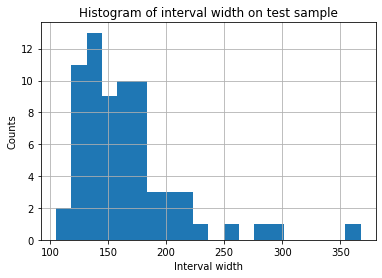

In [23]:
pd.Series(predictions_with_interval[:,2] - predictions_with_interval[:,0]).hist(bins=20)
plt.title('Histogram of interval width on test sample')
plt.xlabel("Interval width")
plt.ylabel("Counts")
plt.show()